# Self-driving car Nanodegree - Term 1

## Project 2: **Behavior Cloning** 
***
In this project, we will use deep neural networks and convolutional neural networks to clone driving behavior. The model will output a steering angle to an autonomous vehicle. We will develop an algorithm pipeline to detect lane lines in images. In addition to implementing code, there is a brief [writeup](https://github.com/tranlyvu/autonomous-vehicle-projects/blob/master/Behavioral%20Cloning/writeup.md)

#### Importing packages

In [10]:
import csv
from keras.models import Sequential
from keras.layers import Flatten, Dense, Convolution2D, Cropping2D, Lambda, Dropout
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sklearn
from keras.layers.pooling import MaxPooling2D
# Visualizations will be shown in the notebook.
%matplotlib inline

#### Loading the data

In [13]:
'''Read data'''
rows = []
with open('../../../data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        rows.append(row)

        
images = []
measurements = []
for line in rows[1:]:
    source_path = line[0]
    filename = source_path.split('/')[-1]
    current_path = '../../../data/IMG/' + filename
    image = cv2.imread(current_path)
    images.append(image)
    measurement = float(line[3])
    measurements.append(measurement)

### First attempt
In [my first attempt](https://github.com/tranlyvu/autonomous-vehicle-projects/blob/master/Behavioral%20Cloning/src/first_attempt.py), I used 9-layers network from [end to end learning for self-driving cars](https://arxiv.org/pdf/1604.07316.pdf) by NVIDIA 

1. Pre-processing pipeline
    - Data augmentation: Flipping images
    - Normalization
    - Mean centering
2. NVIDIA original model
    
|Layer   |type    |output filter/neurons|
|--------|--------|--------|
|1       |conv    |24      |
|2       |conv    |36      |
|3       |conv    |48      |
|4       |conv    |64      |
|5       |conv    |64      |
|6       |flattern|1164    |
|7       |relu    |100     |
|8       |relu    |50      |
|9       |relu    |10      |
|10      |relu    |1       |

### Second attempt

However, I detected overfitting in my first attempt, and hence i tried to improved the mode in second model by adding regulation, namely dropout

1. Pre-processing pipeline
    - Data augmentation: Flipping images
    - Normalization
    - Mean centering
2. Modified NVIDIA model
    
|Layer   |type    |output filter/neurons|
|--------|--------|--------|
|1       |conv    |24      |
|        |max_pool|        |
|2       |conv    |36      |
|        |max_pool|        |
|3       |conv    |48      |
|        |max_pool|        |
|4       |conv    |64      |
|        |max_pool|        |
|5       |conv    |64      |
|6       |flattern|1164    |
|7       |relu    |100     |
|8       |relu    |50      |
|9       |relu    |10      |
|10      |relu    |1       |

In [27]:
augmented_images, augmented_measurements = [], []
for image, measurement in zip(images, measurements):
    image_flipped = np.fliplr(image)
    measurement_flipped = measurement * (-1)
    augmented_images.append(image)
    augmented_images.append(image_flipped)
    augmented_measurements.append(measurement)
    augmented_measurements.append(measurement_flipped)

X_train = np.array(augmented_images)
y_train = np.array(augmented_measurements)

model = Sequential()
#The cameras in the simulator capture 160 pixel by 320 pixel images., after cropping, it is 90x320
model.add(Cropping2D(cropping = ((50,20), (0,0)),input_shape=(160, 320, 3)))
model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(90, 320, 3)))
model.add(Convolution2D(24, 5, 5, subsample=(2,2), activation='relu'))
model.add(Dropout(.5))
model.add(Convolution2D(36, 5, 5, subsample=(2,2), activation='relu'))
model.add(Dropout(.5))
model.add(Convolution2D(48, 5, 5, subsample=(2,2), activation='relu'))
model.add(Convolution2D(64, 3, 3, activation='relu'))
model.add(Convolution2D(64, 3, 3, activation='relu'))  
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

#### Training

In [28]:
'''Training: using MSE for regression'''
model.compile(loss='mse', optimizer='adam')
def generator(samples, batch_size = 32):
    num_samples = len(samples)
    while 1:
        sklearn.utils.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset + batch_size]
            images = []
            angles = []
            for batch_sample in batch_samples:
                name = '../../../data/IMG/' + batch_sample[0].split('/')[-1]
                center_image = cv2.imread(name)
                center_angle = float(batch_sample[3])
                images.append(center_image)
                angles.append(center_angle)

            # trim image to only see section with road
            x_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(x_train, y_train)
            
train_samples, validation_samples = train_test_split(rows[1:], test_size = 0.2)

train_generator = generator(train_samples, batch_size = 32)
validation_generator = generator(validation_samples, batch_size = 32)

history_object = model.fit_generator(train_generator,
                                    samples_per_epoch = len(train_samples),
                                    validation_data = validation_generator,
                                    nb_val_samples = len(validation_samples),
                                    nb_epoch = 32)

Epoch 1/80
6428/6428 [==============================] - 18s - loss: 0.0213 - val_loss: 0.0165
Epoch 2/80
6428/6428 [==============================] - 18s - loss: 0.0168 - val_loss: 0.0166
Epoch 3/80
6428/6428 [==============================] - 18s - loss: 0.0168 - val_loss: 0.0166
Epoch 4/80
6428/6428 [==============================] - 18s - loss: 0.0168 - val_loss: 0.0166
Epoch 5/80
6428/6428 [==============================] - 18s - loss: 0.0168 - val_loss: 0.0166
Epoch 6/80
6428/6428 [==============================] - 18s - loss: 0.0168 - val_loss: 0.0166
Epoch 7/80
6428/6428 [==============================] - 18s - loss: 0.0168 - val_loss: 0.0166
Epoch 8/80
6428/6428 [==============================] - 18s - loss: 0.0168 - val_loss: 0.0166
Epoch 9/80
6428/6428 [==============================] - 18s - loss: 0.0168 - val_loss: 0.0166
Epoch 10/80
6428/6428 [==============================] - 18s - loss: 0.0168 - val_loss: 0.0166
Epoch 11/80
6428/6428 [==============================] - 18

dict_keys(['val_loss', 'loss'])


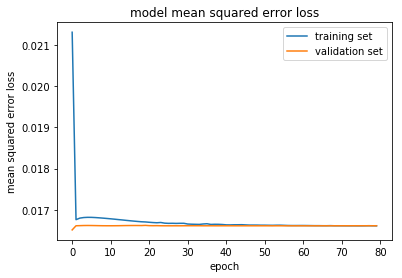

In [29]:
model.save('model.h5')
print(history_object.history.keys())
###plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()